### Test the trained model on data distribution

In [3]:
import random
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import learn2learn as l2l
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
# The corase reconstruction is the rss of the zerofilled multi-coil kspaces
# after inverse FT.
from functions.data.transforms import UnetDataTransform_norm, normalize
# Import a torch.utils.data.Dataset class that takes a list of data examples, a path to those examples
# a data transform and outputs a torch dataset.
from functions.data.mri_dataset import SliceDataset
# Unet architecture as nn.Module
from functions.models.unet import Unet
# Function that returns a MaskFunc object either for generatig random or equispaced masks
from functions.data.subsample import create_mask_for_mask_type
# Implementation of SSIMLoss
from functions.training.losses import SSIMLoss

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# seed
random.seed(1)
np.random.seed(1)
torch.cuda.manual_seed(1)
torch.manual_seed(1)

### Inference

Load data

In [4]:
path_val = '/cheng/metaMRI/metaMRI/data_dict_narrowSlices/knee_val_PDFS_Aera.yaml'
#path_val = '/cheng/metaMRI/metaMRI/data_dict_narrowSlices/knee_val_PD_Skyra.yaml'
#path_val = '/cheng/metaMRI/metaMRI/data_dict_narrowSlices/knee_val_PDFS_Aera.yaml'

# mask function and data transform
mask_function = create_mask_for_mask_type(mask_type_str = 'random', self_sup = False, 
                    center_fraction = 0.08, acceleration = 4.0, acceleration_total = 3.0)
data_transform_val = UnetDataTransform_norm('multicoil', mask_func = mask_function, use_seed=True, mode='val')

# dataset: num_sample_subset x 3
valset = SliceDataset(dataset = path_val, path_to_dataset='', path_to_sensmaps=None, provide_senmaps=False, 
                      challenge="multicoil", transform=data_transform_val, use_dataset_cache=True)

# dataloader: batch size 1 
val_dataloader = torch.utils.data.DataLoader(dataset = valset, batch_size = 1, shuffle = False, 
                                generator = torch.Generator().manual_seed(1), pin_memory = True)

iterator = iter(val_dataloader)


Load model

In [41]:
checkpoint_path = '/cheng/metaMRI/metaMRI/save/E6.1_train_SSIM_kneePDFS_Aera/E6.1_train_SSIM_kneePDFS_Aera_E20_best.pth'
model = Unet(in_chans=1, out_chans=1, chans=32, num_pool_layers=4, drop_prob=0.0)
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device).eval()

Renew the data

In [48]:
batch = next(iterator)
input_image, target_image, mean, std, fname, slice_num = batch
input_image = input_image.to(device)
target_image = target_image.to(device)
std = std.to(device)
mean = mean.to(device)

output = model(input_image)
output = output * std + mean

# SSIM
ssim_fct = SSIMLoss()
ssim = 1 - ssim_fct(output, target_image, data_range = target_image.max().unsqueeze(0)).item()
ssim

0.7758385539054871

Plot

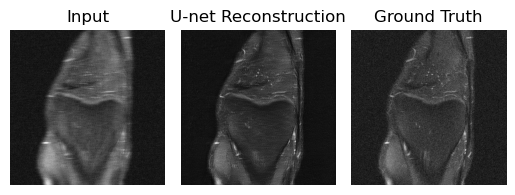

In [30]:
fig, axes = plt.subplots(1, 3)

axes[0].imshow(input_image.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
axes[0].set_title('Input')
axes[0].axis('off')

axes[1].imshow(output.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
axes[1].set_title('U-net Reconstruction')
axes[1].axis('off')

axes[2].imshow(target_image.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
axes[2].set_title('Ground Truth')
axes[2].axis('off')

plt.subplots_adjust(wspace=0.1)
plt.show()